<a href="https://colab.research.google.com/github/sauldnn/PAkrigging/blob/main/Model_perform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Se exporta una serie de tiempo para una estacion específica.
El proposito de este block es medir el comportamiento del método con dos diferentes librerías que resuelven el sistema de ecuaciones.


In [ ]:
#@title Cargue el archivo desde un directorio local. { vertical-output: true }
from google.colab import files
# se debe carga el archivo para procesarlo en cloud
uploaded = files.upload()

In [ ]:
#@title O importe el archivo desde Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Cargue las librerías necesarias e Importe los datos a formato DataFrame. { run: "auto", vertical-output: true }
import io
import pandas as pd
import random
from random import sample
import numpy as np
# set seed for reproducibility

import torch
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# introduzca la ubicación del documento tipo CSV 
directorio ='/content/drive/MyDrive/CUT.csv'
Datos = pd.read_csv(directorio)

# Extrae las columnas correspondientes a la serie temporal (tiempo, valor)
Datos = Datos[['FechaDEC', 'Valor']]
Datos['Valor'] = pd.to_numeric(Datos['Valor'], errors='coerce')
Datos['FechaDEC'] = pd.to_numeric(Datos['FechaDEC'], errors='coerce')

# separar los datos para la validación (train test split)
df = Datos.dropna()
msk =round(len(df)  * (8/10))
train = df[:msk]
test = df[msk:]
llenos = train
huecos = Datos[Datos.isnull().values]

In [ ]:
#@title Train test split { vertical-output: true }
print("Tamaño de datos de entrenamiento {}, desde {} hasta {}".format(len(train), train[['FechaDEC']].min()[0], train[['FechaDEC']].max()[0]))
print("Tamaño de datos de validación {}, desde {} hasta {}".format(len(test), test[['FechaDEC']].min()[0], test[['FechaDEC']].max()[0]))

Tamaño de datos de entrenamiento 42498, desde 2015.00011415525 hasta 2019.848630137
Tamaño de datos de validación 10624, desde 2019.8487442922 hasta 2021.1612021857925


Una vez separado el cojunto como datos llenos y adtos a rellenar, analizamos la gráfica y definimos los metodos de acuerdo a la arquitectura de solución del sistema de ecuaciones.

No handles with labels found to put in legend.


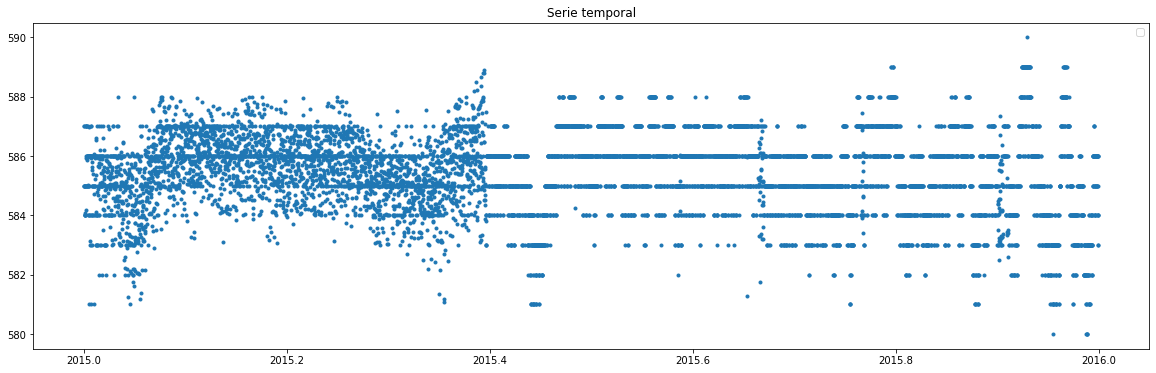

8759


In [ ]:
#@title Imprima una vista previa de la serie temporal. { run: "auto", form-width: "65%" }
import matplotlib.pyplot as plt
#sns.scatterplot(ax =ax, x=llenos['FechaDEC'], y=llenos['Valor'])
test = llenos[llenos['FechaDEC']<2016]
plt.figure(figsize=(20,6))
plt.plot(test['FechaDEC'].tolist(), test['Valor'].tolist(), '.')
plt.title('Serie temporal')
plt.legend()
plt.show()
print(len(test['FechaDEC'].tolist()))



In [ ]:
 llenos[['FechaDEC', 'Valor']]

,FechaDEC,Valor
254208,2015.000114,585.0
254209,2015.000228,585.0
254210,2015.000342,587.0
254211,2015.000457,587.0
254212,2015.000571,585.0
...,...,...
306810,2020.999431,580.4
306811,2020.999545,581.0
306812,2020.999658,581.5
306813,2020.999772,581.9


Buscamos implementar el método diminuyendo el error, por lo que usaremos un conjunto de entrenamiento diferente para cada predicción. 

In [ ]:
#@title Las funciones en esta celda son prototipos de implementación poco eficientes.
def np_method(U, ubic):
    dim = len(U)
    U.append(ubic)
    Distances = [[np.linalg.norm((U[i][0]-U[j][0], U[i][1]-U[j][1])) for i in range(dim+1)] for j in range(dim+1)]
    S = np.array([[1.0 for i in range(dim+2)] for j in range(dim+1)])
    D = np.array(Distances)
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    a = S[:dim+1, :dim+1]
    b = S[0:dim+1, dim+1]
    Sol = np.linalg.solve(a=a, b=b)
    experi = S[0:dim, dim+1]
    result = np.dot(Sol[:dim], experi)
    return result

def torch_method(U, ubic):
    dim = len(U)
    U.append(ubic)
    #Distances = [[torch.dist(torch.tensor(U[i]), torch.tensor(U[j]), 2).item() for i in range(dim+1)] for j in range(dim+1)]
    Distances = [[float(np.linalg.norm((U[i][0]-U[j][0], U[i][1]-U[j][1]))) for i in range(dim+1)] for j in range(dim+1)]
    S = torch.tensor([[1.0 for i in range(dim+2)] for j in range(dim+1)])
    D = torch.tensor(Distances)
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    a = S[:dim+1, :dim+1]
    b = S[0:dim+1, dim+1]
    Sol = torch.linalg.solve(a, b)
    vect = S[0:dim, dim+1]
    result = torch.dot(Sol[:dim], vect)
    return result.item()

La linea de código de las anteriores funciones que más complejidad computacional tiene es la construccion de la matriz de distancias. Por suerte la librería scipy implementa una forma eficiente de calcularla.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


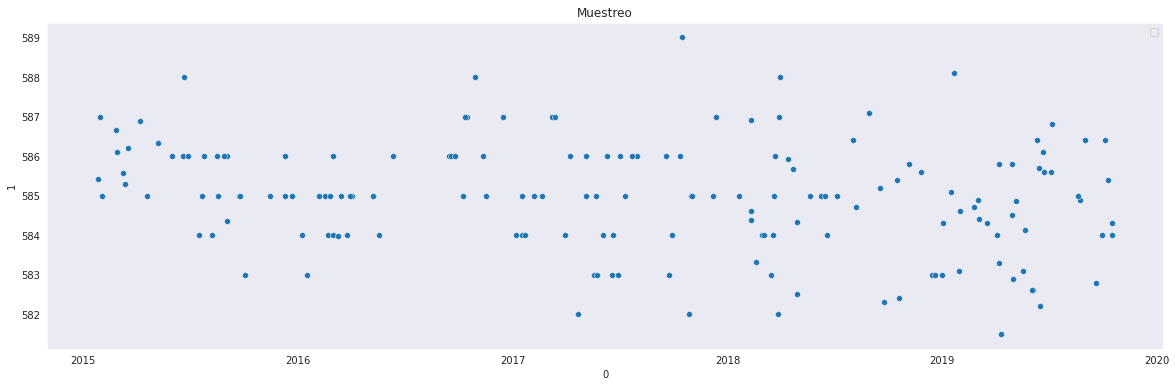

In [ ]:
#@title Make a visualization of the sampling.
# Establezca el tamaño de muestra
nkrig = 24*7
sampl = sample([x for x in range(0,len(llenos))], nkrig)
U = [llenos.iloc[sampl[n]].tolist() for n in range(nkrig)]
df = pd.DataFrame(U)
plt.figure(figsize=(20,6))
sns.set_style("dark")
sns.scatterplot(df[0], df[1])
plt.title('Muestreo')
plt.legend()
plt.show()

In [ ]:
#@title Esta función devuelve los componentes de la ecuación Ax=B y el vector de estimadores para el proceso de solución y obtención de la estimación para el elemento ubic.
def get_components(ubic, U):
  """
  Input:
    ubic: List
      Lista de dimensión (2,1) para el cual se va a calcular el variograma
    U: numpy.ndarray
      Arreglo que contiene los datos del muestreo necesarios para construir el variograma de ubic.
  Output:
    matr: numpy.ndarray
      Matriz de dimensión (nkrig+1, nkrig+1) que contiene los coeficientes del sistema de ecuaciones
      creado por el variograma
    equ: numpy.ndarray
      Vector de dimensión (1, nkrig+1) que contiene el RHS de la ecuación Ax=b
    to_mult: numpy.ndarray
      Vector de estimadores de dimensión (1, nkrig)

  """
  dim = len(U)
  U.append(ubic)
  Distances = distance_matrix(U, U).tolist()
  S = np.ones((dim+1, dim+2))
  D = np.array(Distances)
  S[0:dim, 0:dim] = D[:dim,:dim]
  S[dim, dim] = 0.0
  S[0:dim, dim+1] = D[0:dim, dim]
  matr = S[:dim+1, :dim+1]
  equ = S[0:dim+1, dim+1]
  to_mult = S[:dim, dim+1]
  return matr, equ, to_mult

In [ ]:
#version para get_components()

matrices = []
equals = []
to_multi = []
timein = time.time()
for i in range(1000):
  ubic = [huecos.iloc[i].FechaDEC, 1]
  while True:
      # calculamos el muestreo y las matrices y vectores.
      sampl = sample([x for x in range(0,len(llenos))], 24*7)
      U = llenos.sample(n=nkrig, random_state=np.random.seed(i)).sort_index().values.tolist()
      matr, equ, to_mul = get_components(ubic, U)
      if np.linalg.det(matr)>0.0: 
        partial = time.time()
        to_multi.append(to_mul)
        matrices.append(matr)
        equals.append(equ)
        #else: pass
        break
      else: pass

torch.set_default_tensor_type("torch.cuda.FloatTensor")
A = torch.tensor(matrices)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
b = torch.tensor(equals)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
soluciones = torch.linalg.solve(A, b)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
producto = torch.tensor(to_multi)
print(soluciones[:torch.tensor(to_multi).shape[1]].shape)
print(torch.tensor(to_multi).shape)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
reemplazo = [torch.dot(soluciones[i][:torch.tensor(to_multi).shape[1]], producto[i]).item() for i in range(A.shape[0])]
timefin = time.time() - timein
print(timefin)
print(pd.DataFrame(reemplazo))

RuntimeError: ignored

In [ ]:
def torch_components(ubic, U):
    dim = len(U)
    U.append(ubic)
    Distances = distance_matrix(U, U).tolist()
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    S = torch.ones(dim+1, dim+2)
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    D = torch.tensor(Distances)
    S[0:dim, 0:dim] = D[:dim,:dim]
    S[dim, dim] = 0.0
    S[0:dim, dim+1] = D[0:dim, dim]
    matr = S[:dim+1, :dim+1]
    equ = S[0:dim+1, dim+1]
    to_mult = S[:dim, dim+1]
    return matr, equ, to_mult

In [ ]:
def get_tensor(train_data: pandas.core.frame.DataFrame, inicio: int, n_bloques=3000: int):
  matrices = []
  equals = []
  to_dot = []
  for i in range(inicio, inicio + n_bloques):
    f_time.append([i, float(time.time()-timein)])
    ubic = [huecos.iloc[i].FechaDEC, 0]
    while True:
        # calculamos el muestreo y las matrices y vectores.
        U = llenos.sample(n=n2, random_state=np.random.seed(i)).sort_index().values.tolist()
        matr, equ, to_mul = torch_components(ubic, U)
        if np.linalg.det(matr.tolist())>0.0:
          partial = time.time()
          to_dot.append(to_mul.tolist())
          matrices.append(matr.tolist())
          equals.append(equ.tolist())
          break
        else: pass
  return matrices, equals, to_dot
  

In [ ]:
def contruc_torch(f_time, matrices, equals, to_multi)
  f_time.append([i, float(time.time()-timein)])
  ubic = [huecos.iloc[i].FechaDEC, 0]
  while True:
      # calculamos el muestreo y las matrices y vectores.
      U = llenos.sample(n=n2, random_state=np.random.seed(i)).sort_index().values.tolist()
      matr, equ, to_mul = torch_components(ubic, U)
      if np.linalg.det(matr.tolist())>0.0:
        partial = time.time()
        to_multi.append(to_mul.tolist())
        matrices.append(matr.tolist())
        equals.append(equ.tolist())
        break
      else: pass

In [ ]:
#version para torch_components()

f_time = []
matrices = []
equals = []
to_multi = []
timein = time.time()
for i in range(1000):
  f_time.append([i, float(time.time()-timein)])
  ubic = [huecos.iloc[i].FechaDEC, 0]
  while True:
      # calculamos el muestreo y las matrices y vectores.
      U = llenos.sample(n=n2, random_state=np.random.seed(i)).sort_index().values.tolist()
      matr, equ, to_mul = torch_components(ubic, U)
      if np.linalg.det(matr.tolist())>0.0:
        partial = time.time()
        to_multi.append(to_mul.tolist())
        matrices.append(matr.tolist())
        equals.append(equ.tolist())
        break
      else: pass

torch.set_default_tensor_type("torch.cuda.FloatTensor")
A = torch.tensor(matrices)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
b = torch.tensor(equals)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
soluciones = torch.linalg.solve(A, b)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
producto = torch.tensor(to_multi)
print(soluciones[:torch.tensor(to_multi).shape[1]].shape)
print(torch.tensor(to_multi).shape)
torch.set_default_tensor_type("torch.cuda.FloatTensor")
reemplazo = [[huecos.iloc[i].FechaDEC, torch.dot(soluciones[i][:torch.tensor(to_multi).shape[1]], producto[i]).item()] for i in range(A.shape[0])]
timefin = time.time() - timein
print(timefin)
print(pd.DataFrame(reemplazo))

torch.Size([168, 169])
torch.Size([1000, 168])
34.04121375083923
               0           1
0    1986.000114  582.017822
1    1986.000228  580.876099
2    1986.000342  580.727722
3    1986.000457  580.031372
4    1986.000571  581.405029
..           ...         ...
995  1986.113699  580.461548
996  1986.113813  580.781738
997  1986.113927  581.049377
998  1986.114041  580.604065
999  1986.114155  579.828369

[1000 rows x 2 columns]


Text(0.5, 1.0, 'Serie temporal')

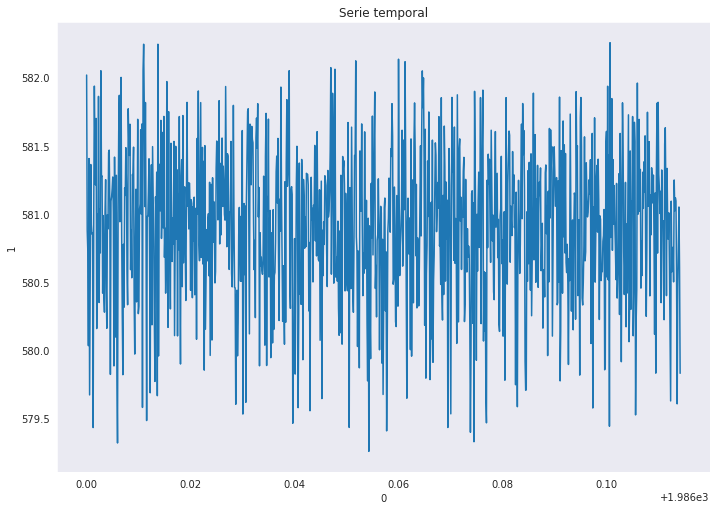

In [ ]:
import matplotlib.pyplot as plt
rem = pd.DataFrame(reemplazo)
sns.set_style("dark")
plt.figure(figsize=(20,6))
sns.lineplot(x=rem[0], y=rem[1])
plt.title('Serie temporal')

In [ ]:
#@title Medicion del tiempo de ejecución indiviadualmente. { run: "auto", vertical-output: true }
import time
from scipy.spatial import distance_matrix
# bloque 1
timein = time.time()
ubic = [huecos.iloc[100].FechaDEC, 0]
print("bloque 1", time.time()-timein)

# bloque 2
timein2 = time.time()
U = llenos.sample(n=nkrig, random_state=np.random.seed(0)).values.tolist()
dim = len(U)
U.append(ubic)
print("bloque 2", time.time()-timein2)

# bloque 3
timein3 = time.time()
Distances = distance_matrix(U, U)
print("bloque 3", time.time()-timein3)

# bloque 4
timein4 = time.time()
S = np.ones((dim+1, dim+2))
D = np.array(Distances)
S[0:dim, 0:dim] = D[:dim,:dim]
S[dim, dim] = 0.0
S[0:dim, dim+1] = D[0:dim, dim]
matr = S[:dim+1, :dim+1]
equ = S[0:dim+1, dim+1]
to_mult = S[:dim, dim+1]
print("bloque 4", time.time()-timein4)
print("tiempo total: ", time.time()-timein)

bloque 1 0.0004906654357910156
bloque 2 0.0032393932342529297
bloque 3 0.003996610641479492
bloque 4 0.0017693042755126953
tiempo total:  0.010950088500976562


In [ ]:
#@title Para medir el comportamiento del modelo se crea una función que realiza la interpolación en función de las dimensiones del tensor.
def cambio_dbloques(n1, n2):
  f_time = []
  matrices = []
  equals = []
  to_multi = []
  timein = time.time()
  for i in range(n1):
    #if i%100==99:
      #print(i, time.time()-timein)
    #f_time.append([i, float(time.time()-timein)])
    ubic = [huecos.iloc[i].FechaDEC, 0]
    while True:
        U = llenos.sample(n=n2, random_state=np.random.seed(i)).sort_index().values.tolist()
        matr, equ, to_mul = torch_components(ubic, U)
        if np.linalg.det(matr.tolist())>0.0:
          #partial = time.time()
          to_multi.append(to_mul.tolist())
          matrices.append(matr.tolist())
          equals.append(equ.tolist())
          break
        else: pass

  torch.set_default_tensor_type("torch.cuda.FloatTensor")
  A = torch.tensor(matrices)
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
  b = torch.tensor(equals)
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
  soluciones = torch.linalg.solve(A, b)
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
  producto = torch.tensor(to_multi)
  #print(soluciones[:torch.tensor(to_multi).shape[1]].shape)
  #print(torch.tensor(to_multi).shape)
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
  reemplazo = [torch.dot(soluciones[i][:torch.tensor(to_multi).shape[1]], producto[i]).item() for i in range(A.shape[0])]
  #timefin = time.time() - timein
  return time.time() - timein
  #print(timefin)
  #print(pd.DataFrame(reemplazo))

In [ ]:
#@title Se fija una dimensión del tensor y se obtienen los tiempos de ejecución en función del número de entradas del tensor.
tiempos = []
for n in list(range(500, 5000, 500)):
   tiempos.append([n, cambio_dbloques(n, nkrig)])
tiempos = pd.DataFrame(tiempos, columns=['nvalores', 'tiempo'])


Text(0.5, 1.0, 'Tiempo de ejecución.')

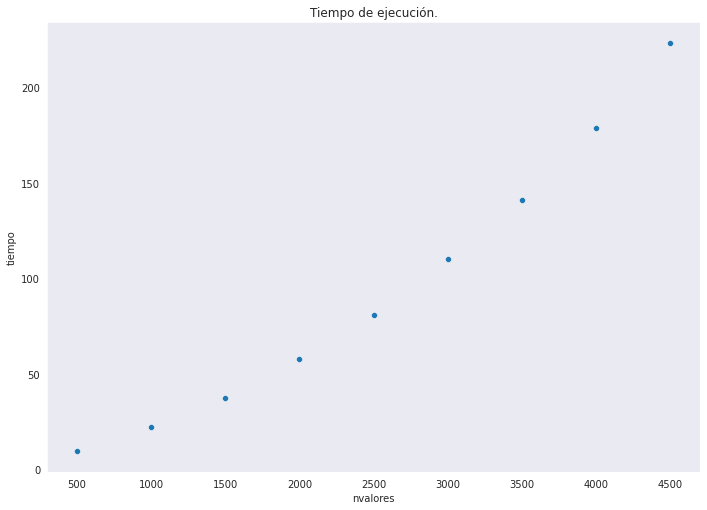

In [ ]:
#@title Gráfica de la función del tiempo con la dimensión de cada entrada fija y el numero de entradas variando

sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x=tiempos['nvalores'], y=tiempos['tiempo'])
plt.title('Tiempo de ejecución.')

In [ ]:
#@title Se repite el ejercicio variando el segundo parametro, es decir el tamaño de las entradas del tensor
tiempos = []
for n in list(range(20, 200, 10)):
   tiempos.append([n, cambio_dbloques(3000, n)])
tiempos = pd.DataFrame(tiempos, columns=['nvalores', 'tiempo'])


Text(0.5, 1.0, 'Tiempo de ejecución.')

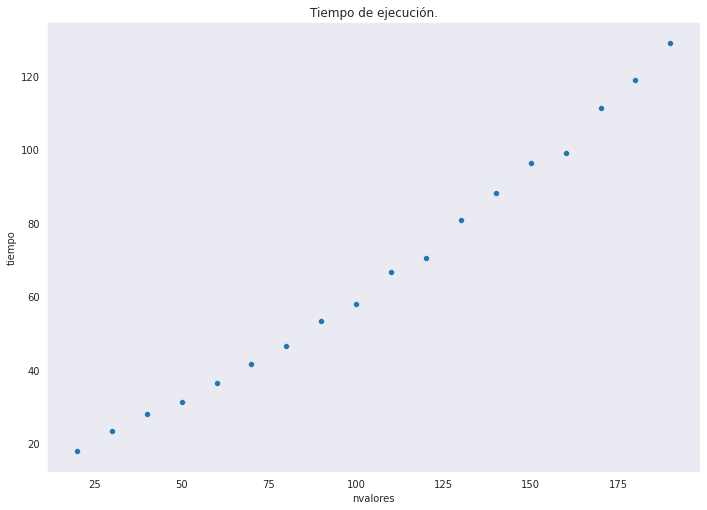

In [ ]:
#@title Gráfica de la función del tiempo con la dimensión del tensor fija y la dimensión de entradas variando
sns.set_style("dark")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x=tiempos['nvalores'], y=tiempos['tiempo'])
plt.title('Tiempo de ejecución.')

In [ ]:
def model_compilation(df_train, huecos, nkrig, nbloques):
  n_iteraciones = len(huecos)
  dim_inter = round(n_iteraciones/10) if n_iteraciones<nkrig else nkrig
  lista_diteraciones = list(range(0, n_iteraciones, nbloques))
  reemplazo = []
  print(n_iteraciones)
  timex = time.time()
  for n in lista_diteraciones:
    fin = n+nbloques if n+nbloques<n_iteraciones else n_iteraciones
    print(n, "-", fin, time.time()-timex)
    timex = time.time()    
    matrices = []
    equals = []
    to_multi = []
    for i in range(n, fin):
      ubic = [huecos.iloc[i].FechaDEC, 0]
      while True:
        U = df_train.sample(n=dim_inter, random_state=np.random.seed(i)).sort_index().values.tolist()
        matr, equ, to_mul = get_components(ubic, U)
        if np.linalg.det(matr.tolist())>0.0:
          partial = time.time()
          to_multi.append(to_mul.tolist())
          matrices.append(matr.tolist())
          equals.append(equ.tolist())
          break
        else: pass
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    A = torch.tensor(matrices)
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    b = torch.tensor(equals)
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    soluciones = torch.linalg.solve(A, b)
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    producto = torch.tensor(to_multi)
    #print(soluciones[:torch.tensor(to_multi).shape[1]].shape)
    #print(torch.tensor(to_multi).shape)
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    reemplazo = reemplazo + [[huecos.iloc[i].FechaDEC, torch.dot(soluciones[i][:torch.tensor(to_multi).shape[1]], producto[i]).item()] for i in range(A.shape[0])]
  return pd.DataFrame(data=reemplazo, columns=['FechaDEC', 'Valor'])

In [ ]:
pred_test[]

,FechaDEC,valor
0,2019.848744,580.988281
1,2019.848858,581.257690
2,2019.848973,579.696350
3,2019.849087,580.689392
4,2019.849201,580.227966
...,...,...
10619,2020.004326,580.761292
10620,2020.004440,579.999634
10621,2020.004554,580.286804
10622,2020.004668,580.528503


In [ ]:
def relative_error(y:list, y_hat:list):
  if len(y)==len(y_hat): 
    error_day = [abs(y1-y2) for (y1, y2) in zip(y, y_hat)]
    mean_error = (1/len(y)) * sum(error_day)
    return mean_error
  else: return -1

In [ ]:
relative_error([1, 2, 3], [1.1, 2.2])

-1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

#df = pd.DataFrame(np.random.rand(10, 2), columns=['Valor', 'FechaDEC'])
tscv = TimeSeriesSplit(max_train_size=None, n_splits=6)
index = range(len(df))
errors = []
for train_index, test_index in tscv.split(index):
  d_train, d_test = df.iloc[train_index], df.iloc[test_index]
  d_hat = model_compilation(d_train, d_test, 24*7, 2000)
  error_i = relative_error(d_test['Valor'].tolist(), d_hat['Valor'].tolist())
  print(error_i)
  errors.append(error_i)


7588
0 - 2000 1.6689300537109375e-06
2000 - 4000 62.17224478721619
4000 - 6000 61.16555643081665
6000 - 7588 60.03695368766785
7588
0 - 2000 1.9073486328125e-06
2000 - 4000 60.635753870010376
4000 - 6000 61.12686204910278
6000 - 7588 61.82701086997986
7588
0 - 2000 2.384185791015625e-06
2000 - 4000 62.41262650489807
4000 - 6000 62.691221952438354
6000 - 7588 63.62076663970947
7588
0 - 2000 1.9073486328125e-06
2000 - 4000 63.297728300094604
4000 - 6000 64.08002138137817
6000 - 7588 61.984307050704956
7588
0 - 2000 1.6689300537109375e-06
2000 - 4000 63.93725895881653
4000 - 6000 63.45467734336853
6000 - 7588 65.28460550308228
7588
0 - 2000 2.384185791015625e-06
2000 - 4000 64.1752564907074
4000 - 6000 66.35843706130981
6000 - 7588 64.36841130256653


In [ ]:
validation = sum(errors) / (len(errors))
validation

4.342131395475473

Text(0.5, 0, 'Datos usados')

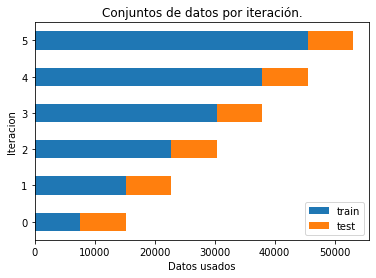

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
#df = pd.DataFrame(np.random.rand(10, 2), columns=['Valor', 'FechaDEC'])
tscv = TimeSeriesSplit(max_train_size=None, n_splits=6)
index = range(len(df))
errors = []
medidas = [[len(train_index), len(test_index)] for train_index, test_index in tscv.split(index)]
panda = pd.DataFrame(medidas, columns=["train", "test"])
panda.plot(kind="barh", stacked=True)
plt.title("Conjuntos de datos por iteración.")
plt.ylabel("Iteracion")
plt.xlabel("Datos usados")